#### Top

# Chapter 8 Data Import and Export

* [8.0 Imports and Setup](#8.0-Imports-and-Setup)
* [8.1 Introduction](#8.1-Introduction)
* [8.2 Importing Data](#8.2-Importing-Data)
* [8.3 Exporting to CSV](#8.3-Exporting-to-CSV)
* [8.4 Exporting to JSON](#8.4-Exporting-to-JSON)
* [8.5 Reading JSON](#8.5-Reading-JSON)
* [8.6 Custom JSON Handling](#8.6-Custom-JSON-Handling)
* [8.7 Munging JSON](#8.7-Munging-JSON)
* [8.8 Exporting to Excel](#8.8-Exporting-to-Excel)
* [8.9 Exporting to Parquet](#8.9-Exporting-to-Parquet)
* [8.10 Exporting to SQL](#8.10-Exporting-to-SQL)
* [8.11 Using Arrow to Convert DataFrames](#8.11-Using-Arrow-to-Convert-DataFrames)
* [8.12 Converting to Pandas](#8.12-Converting-to-Pandas)
* [8.13 Working with Other Libraries](#8.13-Working-with-Other-Libraries)
* [8.14 Using XGBoost to Predict Mileage](#8.14-Using-XGBoost-to-Predict-Mileage)
* [8.15 Plotting Residuals with Matplotlib](#8.15-Plotting-Residuals-with-Matplotlib)
* [8.16 PCA of the Autos Data](#8.16-PCA-of-the-Autos-Data)
* [8.17 Polars Configuration](#8.17-Polars-Configuration)

---
# 8.0 Imports and Setup

[back to Top](#Top)

In [1]:
import polars as pl
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
import chardet
import pprint as pp
import hvplot.polars
hvplot.extension('matplotlib')

matplotlib_inline.backend_inline.set_matplotlib_formats("retina")
pd.options.mode.copy_on_write = True
print(pd.options.mode.copy_on_write)
pl.Config.set_verbose(True)
pl.show_versions()

def HR():
    print("-"*40)

@pl.Config(tbl_cols=-1, ascii_tables=True)
def tight_layout(df: pl.DataFrame, n=5) -> None:
    with pl.Config(tbl_cols=-1, fmt_str_lengths=n):
        print(df)

def detect_encoding(filename: str) -> str:
    """Return the most probable character encoding for a file."""
    with open(filename, "rb") as f:
        raw_data = f.read()
        print(raw_data)
        result = chardet.detect(raw_data)
        return result["encoding"]

True
--------Version info---------
Polars:              1.9.0
Index type:          UInt32
Platform:            macOS-12.7.6-x86_64-i386-64bit
Python:              3.11.5 (main, Jan 16 2024, 17:25:53) [Clang 14.0.0 (clang-1400.0.29.202)]

----Optional dependencies----
adbc_driver_manager  1.1.0
altair               5.4.0
cloudpickle          3.0.0
connectorx           0.3.3
deltalake            0.19.1
fastexcel            0.11.6
fsspec               2023.12.2
gevent               24.2.1
great_tables         0.10.0
matplotlib           3.9.2
nest_asyncio         1.6.0
numpy                2.0.2
openpyxl             3.1.5
pandas               2.2.2
pyarrow              17.0.0
pydantic             2.8.2
pyiceberg            0.6.1
sqlalchemy           2.0.32
torch                <not installed>
xlsx2csv             0.8.3
xlsxwriter           3.2.0


---
# 8.1 Introduction
[back to Top](#Top)

Explore how to import and export data in different formats with Polars.


---
# 8.2 Importing Data
[back to Top](#Top)

* Use the Fuel Economy dataset.

In [2]:
path = 'data/vehicles.csv'
raw = pl.read_csv(path, null_values=['NA'])
raw.glimpse(max_items_per_column=2)

Rows: 48202
Columns: 84
$ barrels08        <f64> 14.167142857142858, 27.04636363636364
$ barrelsA08       <f64> 0.0, 0.0
$ charge120        <f64> 0.0, 0.0
$ charge240        <f64> 0.0, 0.0
$ city08           <i64> 19, 9
$ city08U          <f64> 0.0, 0.0
$ cityA08          <i64> 0, 0
$ cityA08U         <f64> 0.0, 0.0
$ cityCD           <f64> 0.0, 0.0
$ cityE            <f64> 0.0, 0.0
$ cityUF           <f64> 0.0, 0.0
$ co2              <i64> -1, -1
$ co2A             <i64> -1, -1
$ co2TailpipeAGpm  <f64> 0.0, 0.0
$ co2TailpipeGpm   <f64> 423.1904761904762, 807.9090909090909
$ comb08           <i64> 21, 11
$ comb08U          <f64> 0.0, 0.0
$ combA08          <i64> 0, 0
$ combA08U         <f64> 0.0, 0.0
$ combE            <f64> 0.0, 0.0
$ combinedCD       <f64> 0.0, 0.0
$ combinedUF       <f64> 0.0, 0.0
$ cylinders        <i64> 4, 12
$ displ            <f64> 2.0, 4.9
$ drive            <str> 'Rear-Wheel Drive', 'Rear-Wheel Drive'
$ engId            <i64> 9011, 22020
$ eng_dscr         <st

avg line length: 434.78027
std. dev. line length: 23.885818
initial row estimate: 47850
no. of chunks: 4 processed by: 4 threads.


In [3]:
def tweak_auto(df):
    cols=[
        'year', 'make', 'model', 'displ', 'cylinders',
        'trany', 'drive', 'VClass', 'fuelType', 'barrels08',
        'city08', 'highway08', 'createdOn'
    ]
    return (
        df
        .select(pl.col(cols))
        .with_columns(
            pl.col('year').cast(pl.Int16),
            pl.col(['cylinders', 'highway08', 'city08']).cast(pl.UInt8),
            pl.col(['displ', 'barrels08']).cast(pl.Float32),
            pl.col(['make', 'model', 'VClass', 'drive', 'fuelType']).cast(pl.Categorical),
            pl.col('createdOn').str.to_datetime('%a %b %d %H:%M:%S %Z %Y'),
            is_automatic=pl.col('trany').str.contains('Auto'),
            num_gears=pl.col('trany').str.extract(r'(\d+)').cast(pl.Int8)
        )
    )

autos = tweak_auto(raw)

/var/folders/sb/p6dz60l562q8pzfgzf74gsxm0000gn/T/ipykernel_2086/838758848.py:10: CategoricalRemappingWarning: Local categoricals have different encodings, expensive re-encoding is done to perform this merge operation. Consider using a StringCache or an Enum type if the categories are known in advance
  .with_columns(


* `read_csv()` and `scan_csv()` are the main mechanisms for ingesting CSV data.
* They include options for parsing dates.
* However, it is generally better to explicitly handle dates later in the tweak pipeline because the CSV parser can silently fail to convert dates. 

---
# 8.3 Exporting to CSV
[back to Top](#Top)

* We can export a dataframe to a CSV file using `write_csv()`.
* In this example, we export the `df` dataframe to a CSV format.
* If we don't provide a path, the method will return a string of the CSV data.
* This can let us quickly see the output.

In [4]:
print(
    autos
    .head(3)
    .write_csv()
)

year,make,model,displ,cylinders,trany,drive,VClass,fuelType,barrels08,city08,highway08,createdOn,is_automatic,num_gears
1985,Alfa Romeo,Spider Veloce 2000,2.0,4,Manual 5-spd,Rear-Wheel Drive,Two Seaters,Regular,14.167143,19,25,2013-01-01T00:00:00.000000,false,5
1985,Ferrari,Testarossa,4.9,12,Manual 5-spd,Rear-Wheel Drive,Two Seaters,Regular,27.046364,9,14,2013-01-01T00:00:00.000000,false,5
1985,Dodge,Charger,2.2,4,Manual 5-spd,Front-Wheel Drive,Subcompact Cars,Regular,11.018888,23,33,2013-01-01T00:00:00.000000,false,5



* We can adjust the precision to 2 decimal places.
* The values of *displ* and *barrels08* are now rounded to 2 decimal places.

In [5]:
print(
    autos
    .head(3)
    .write_csv(float_precision=2)
)

year,make,model,displ,cylinders,trany,drive,VClass,fuelType,barrels08,city08,highway08,createdOn,is_automatic,num_gears
1985,Alfa Romeo,Spider Veloce 2000,2.00,4,Manual 5-spd,Rear-Wheel Drive,Two Seaters,Regular,14.17,19,25,2013-01-01T00:00:00.000000,false,5
1985,Ferrari,Testarossa,4.90,12,Manual 5-spd,Rear-Wheel Drive,Two Seaters,Regular,27.05,9,14,2013-01-01T00:00:00.000000,false,5
1985,Dodge,Charger,2.20,4,Manual 5-spd,Front-Wheel Drive,Subcompact Cars,Regular,11.02,23,33,2013-01-01T00:00:00.000000,false,5



---
# 8.4 Exporting to JSON
[back to Top](#Top)

* We can export a dataframe to JSON using `.write_json()`.
* Polars embeds type information in the JSON file.
* This makes it possible to read the JSON file back into a dataframe with the correct data types.
* However, other applications may not read the data types from the JSON file.
* In that case, it may be better to use more efficient formats, such as Parquet or Arrow.
* Here, export the first 3 rows of the *autos* dataframe to a JSON file.

In [6]:
import pprint
import json

pp = pprint.PrettyPrinter(indent=1, compact=False)

pp.pprint(json.loads(autos.head(2).write_json()))

[{'VClass': 'Two Seaters',
  'barrels08': 14.167143,
  'city08': 19,
  'createdOn': '2013-01-01 00:00:00',
  'cylinders': 4,
  'displ': 2.0,
  'drive': 'Rear-Wheel Drive',
  'fuelType': 'Regular',
  'highway08': 25,
  'is_automatic': False,
  'make': 'Alfa Romeo',
  'model': 'Spider Veloce 2000',
  'num_gears': 5,
  'trany': 'Manual 5-spd',
  'year': 1985},
 {'VClass': 'Two Seaters',
  'barrels08': 27.046364,
  'city08': 9,
  'createdOn': '2013-01-01 00:00:00',
  'cylinders': 12,
  'displ': 4.9,
  'drive': 'Rear-Wheel Drive',
  'fuelType': 'Regular',
  'highway08': 14,
  'is_automatic': False,
  'make': 'Ferrari',
  'model': 'Testarossa',
  'num_gears': 5,
  'trany': 'Manual 5-spd',
  'year': 1985}]


* `read_json()` can read the JSON file back into a dataframe.

In [7]:
from io import StringIO

(
    pl.read_json(StringIO(autos.write_json()))
)

year,make,model,displ,cylinders,trany,drive,VClass,fuelType,barrels08,city08,highway08,createdOn,is_automatic,num_gears
i64,str,str,f64,i64,str,str,str,str,f64,i64,i64,str,bool,i64
1985,"""Alfa Romeo""","""Spider Veloce 2000""",2.0,4,"""Manual 5-spd""","""Rear-Wheel Drive""","""Two Seaters""","""Regular""",14.167143,19,25,"""2013-01-01 00:00:00""",false,5
1985,"""Ferrari""","""Testarossa""",4.9,12,"""Manual 5-spd""","""Rear-Wheel Drive""","""Two Seaters""","""Regular""",27.046364,9,14,"""2013-01-01 00:00:00""",false,5
1985,"""Dodge""","""Charger""",2.2,4,"""Manual 5-spd""","""Front-Wheel Drive""","""Subcompact Cars""","""Regular""",11.018888,23,33,"""2013-01-01 00:00:00""",false,5
1985,"""Dodge""","""B150/B250 Wagon 2WD""",5.2,8,"""Automatic 3-spd""","""Rear-Wheel Drive""","""Vans""","""Regular""",27.046364,10,12,"""2013-01-01 00:00:00""",true,3
1993,"""Subaru""","""Legacy AWD Turbo""",2.2,4,"""Manual 5-spd""","""4-Wheel or All-Wheel Drive""","""Compact Cars""","""Premium""",15.658421,17,23,"""2013-01-01 00:00:00""",false,5
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
1993,"""Subaru""","""Legacy""",2.2,4,"""Automatic 4-spd""","""Front-Wheel Drive""","""Compact Cars""","""Regular""",13.523182,19,26,"""2013-01-01 00:00:00""",true,4
1993,"""Subaru""","""Legacy""",2.2,4,"""Manual 5-spd""","""Front-Wheel Drive""","""Compact Cars""","""Regular""",12.935218,20,28,"""2013-01-01 00:00:00""",false,5
1993,"""Subaru""","""Legacy AWD""",2.2,4,"""Automatic 4-spd""","""4-Wheel or All-Wheel Drive""","""Compact Cars""","""Regular""",14.167143,18,24,"""2013-01-01 00:00:00""",true,4


* It can be much harder reading JSON from other sources.
* Here, we export the first 3 rows using Pandas and see if we can read it back into Polars.
* If we export with Pandas 'records' orientation, we can read it back into Polars.
* However, if we use the default 'columns' orientation, we will not be able to cleanly read it back into Polars.

In [8]:
# Export the JSON file with 'records' orientatio.
(
    autos
    .to_pandas()
    .head(3)
    .to_json('./data/pd_records.json', orient='records')
)
!ls -la ./data/pd_records.json

-rw-r--r--  1 gpb  staff  890 10 25 11:17 ./data/pd_records.json


---
* Examine what the export looks like.
* We see the data is in a list of dictionaries
* Each dictionary represents a row in a dataframe.
* The keys are the column names, and the values are the data.

In [9]:
pp.pprint(
    json.loads(autos.head(2).to_pandas().to_json(orient='records'))
)

[{'VClass': 'Two Seaters',
  'barrels08': 14.167142868,
  'city08': 19,
  'createdOn': 1356998400,
  'cylinders': 4,
  'displ': 2.0,
  'drive': 'Rear-Wheel Drive',
  'fuelType': 'Regular',
  'highway08': 25,
  'is_automatic': False,
  'make': 'Alfa Romeo',
  'model': 'Spider Veloce 2000',
  'num_gears': 5,
  'trany': 'Manual 5-spd',
  'year': 1985},
 {'VClass': 'Two Seaters',
  'barrels08': 27.0463638306,
  'city08': 9,
  'createdOn': 1356998400,
  'cylinders': 12,
  'displ': 4.9000000954,
  'drive': 'Rear-Wheel Drive',
  'fuelType': 'Regular',
  'highway08': 14,
  'is_automatic': False,
  'make': 'Ferrari',
  'model': 'Testarossa',
  'num_gears': 5,
  'trany': 'Manual 5-spd',
  'year': 1985}]


* Load this JSON file back into Polars with `read_json()`.

In [10]:
from_pd = pl.read_json('./data/pd_records.json')
from_pd

year,make,model,displ,cylinders,trany,drive,VClass,fuelType,barrels08,city08,highway08,createdOn,is_automatic,num_gears
i64,str,str,f64,f64,str,str,str,str,f64,i64,i64,i64,bool,f64
1985,"""Alfa Romeo""","""Spider Veloce 2000""",2.0,4.0,"""Manual 5-spd""","""Rear-Wheel Drive""","""Two Seaters""","""Regular""",14.167143,19,25,1356998400,false,5.0
1985,"""Ferrari""","""Testarossa""",4.9,12.0,"""Manual 5-spd""","""Rear-Wheel Drive""","""Two Seaters""","""Regular""",27.046364,9,14,1356998400,false,5.0
1985,"""Dodge""","""Charger""",2.2,4.0,"""Manual 5-spd""","""Front-Wheel Drive""","""Subcompact Cars""","""Regular""",11.018888,23,33,1356998400,false,5.0


* We can see that the *createdOn* column has been mutated into an integer.
* We can convert it to a date.
* Use `from_epoch()` to convert the integer to a date.

In [11]:
(
    from_pd
    .with_columns(
        createdOn=pl.from_epoch('createdOn', time_unit='s')
    )
)

year,make,model,displ,cylinders,trany,drive,VClass,fuelType,barrels08,city08,highway08,createdOn,is_automatic,num_gears
i64,str,str,f64,f64,str,str,str,str,f64,i64,i64,datetime[μs],bool,f64
1985,"""Alfa Romeo""","""Spider Veloce 2000""",2.0,4.0,"""Manual 5-spd""","""Rear-Wheel Drive""","""Two Seaters""","""Regular""",14.167143,19,25,2013-01-01 00:00:00,false,5.0
1985,"""Ferrari""","""Testarossa""",4.9,12.0,"""Manual 5-spd""","""Rear-Wheel Drive""","""Two Seaters""","""Regular""",27.046364,9,14,2013-01-01 00:00:00,false,5.0
1985,"""Dodge""","""Charger""",2.2,4.0,"""Manual 5-spd""","""Front-Wheel Drive""","""Subcompact Cars""","""Regular""",11.018888,23,33,2013-01-01 00:00:00,false,5.0


---
# 8.5 Reading JSON
[back to Top](#Top)


In [12]:
from io import StringIO

pl.read_json(StringIO(autos.write_json()))

year,make,model,displ,cylinders,trany,drive,VClass,fuelType,barrels08,city08,highway08,createdOn,is_automatic,num_gears
i64,str,str,f64,i64,str,str,str,str,f64,i64,i64,str,bool,i64
1985,"""Alfa Romeo""","""Spider Veloce 2000""",2.0,4,"""Manual 5-spd""","""Rear-Wheel Drive""","""Two Seaters""","""Regular""",14.167143,19,25,"""2013-01-01 00:00:00""",false,5
1985,"""Ferrari""","""Testarossa""",4.9,12,"""Manual 5-spd""","""Rear-Wheel Drive""","""Two Seaters""","""Regular""",27.046364,9,14,"""2013-01-01 00:00:00""",false,5
1985,"""Dodge""","""Charger""",2.2,4,"""Manual 5-spd""","""Front-Wheel Drive""","""Subcompact Cars""","""Regular""",11.018888,23,33,"""2013-01-01 00:00:00""",false,5
1985,"""Dodge""","""B150/B250 Wagon 2WD""",5.2,8,"""Automatic 3-spd""","""Rear-Wheel Drive""","""Vans""","""Regular""",27.046364,10,12,"""2013-01-01 00:00:00""",true,3
1993,"""Subaru""","""Legacy AWD Turbo""",2.2,4,"""Manual 5-spd""","""4-Wheel or All-Wheel Drive""","""Compact Cars""","""Premium""",15.658421,17,23,"""2013-01-01 00:00:00""",false,5
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
1993,"""Subaru""","""Legacy""",2.2,4,"""Automatic 4-spd""","""Front-Wheel Drive""","""Compact Cars""","""Regular""",13.523182,19,26,"""2013-01-01 00:00:00""",true,4
1993,"""Subaru""","""Legacy""",2.2,4,"""Manual 5-spd""","""Front-Wheel Drive""","""Compact Cars""","""Regular""",12.935218,20,28,"""2013-01-01 00:00:00""",false,5
1993,"""Subaru""","""Legacy AWD""",2.2,4,"""Automatic 4-spd""","""4-Wheel or All-Wheel Drive""","""Compact Cars""","""Regular""",14.167143,18,24,"""2013-01-01 00:00:00""",true,4


---
# 8.6 Custom JSON Handling
[back to Top](#Top)

* Explore loading JSON formatted differently than what Polars expects.
* Export the *autos* data as JSON using the default Pandas orientation, which 'columns'.
* This orientation is a dictionary of column names mapped to a dictionary, mapping the index to the value for that row.
* Here, the index cannot be duplicated for this export. 

In [13]:
import pprint
import json

(
    json.loads(
        autos.head(2)
        .to_pandas()
        .to_json(orient='columns')
    )
)

{'year': {'0': 1985, '1': 1985},
 'make': {'0': 'Alfa Romeo', '1': 'Ferrari'},
 'model': {'0': 'Spider Veloce 2000', '1': 'Testarossa'},
 'displ': {'0': 2.0, '1': 4.9000000954},
 'cylinders': {'0': 4, '1': 12},
 'trany': {'0': 'Manual 5-spd', '1': 'Manual 5-spd'},
 'drive': {'0': 'Rear-Wheel Drive', '1': 'Rear-Wheel Drive'},
 'VClass': {'0': 'Two Seaters', '1': 'Two Seaters'},
 'fuelType': {'0': 'Regular', '1': 'Regular'},
 'barrels08': {'0': 14.167142868, '1': 27.0463638306},
 'city08': {'0': 19, '1': 9},
 'highway08': {'0': 25, '1': 14},
 'createdOn': {'0': 1356998400, '1': 1356998400},
 'is_automatic': {'0': False, '1': False},
 'num_gears': {'0': 5, '1': 5}}

* Save this file 

In [14]:
(
    autos
    .to_pandas()
    .head(3)
    .to_json('./data/pd_columns.json', orient='columns')
)
!ls -la ./data/pd_columns.json

-rw-r--r--  1 gpb  staff  794 10 25 11:17 ./data/pd_columns.json


* When we try to read this data in Polars, it does not error.
* It even get the column names right.
* However, there is only one row, with *struct* type columns.
* It is a single value that contains multiple values.
* Here, it contains all the values for a column.

In [15]:
(
    pl.read_json('./data/pd_columns.json')
)

year,make,model,displ,cylinders,trany,drive,VClass,fuelType,barrels08,city08,highway08,createdOn,is_automatic,num_gears
struct[3],struct[3],struct[3],struct[3],struct[3],struct[3],struct[3],struct[3],struct[3],struct[3],struct[3],struct[3],struct[3],struct[3],struct[3]
"{1985,1985,1985}","{""Alfa Romeo"",""Ferrari"",""Dodge""}","{""Spider Veloce 2000"",""Testarossa"",""Charger""}","{2.0,4.9,2.2}","{4.0,12.0,4.0}","{""Manual 5-spd"",""Manual 5-spd"",""Manual 5-spd""}","{""Rear-Wheel Drive"",""Rear-Wheel Drive"",""Front-Wheel Drive""}","{""Two Seaters"",""Two Seaters"",""Subcompact Cars""}","{""Regular"",""Regular"",""Regular""}","{14.167143,27.046364,11.018888}","{19,9,23}","{25,14,33}","{1356998400,1356998400,1356998400}","{false,false,false}","{5.0,5.0,5.0}"


* Polars has the ability to explode a sequence into multiple rows.
* But this only works with **list** types, not struct types.
* In this demo, we have a dataframe with numeric, struct and list column.

In [16]:
df_num_listy_structy = pl.DataFrame({
    'num': [1,2,3],
    'listy': [[1,2], [3,4], [5,6]],
    'structy':  [{'a': 1, 'b': 2}, {'a': 3, 'b': 4}, {'a': 5, 'b': 6}]
})

df_num_listy_structy

num,listy,structy
i64,list[i64],struct[2]
1,"[1, 2]","{1,2}"
2,"[3, 4]","{3,4}"
3,"[5, 6]","{5,6}"


* The *structy* column is the values from the dictionary in the *struct* column.
* **The keys are lost**


---
* Next, we want to **explode** the nested data into multiple rows.
* We can easily do this in Polars with *list* types.

---
`polars.Expr.explode`

* Explode a list expression.
* This means that every item is expanded to a new row.
* https://docs.pola.rs/py-polars/html/reference/expressions/api/polars.Expr.explode.html

In [17]:
df_num_listy_structy.explode('listy')

num,listy,structy
i64,i64,struct[2]
1,1,"{1,2}"
1,2,"{1,2}"
2,3,"{3,4}"
2,4,"{3,4}"
3,5,"{5,6}"
3,6,"{5,6}"


* However, Polars cannot explode the *struct* type, as it is not a supported operation.

In [18]:
try: 
    print(df_num_listy_structy).explode('structy')
except Exception as e:
    print(e)

shape: (3, 3)
+-----+-----------+-----------+
| num | listy     | structy   |
| --- | ---       | ---       |
| i64 | list[i64] | struct[2] |
+=============================+
| 1   | [1, 2]    | {1,2}     |
| 2   | [3, 4]    | {3,4}     |
| 3   | [5, 6]    | {5,6}     |
+-----+-----------+-----------+
'NoneType' object has no attribute 'explode'


---
* Polars does not allow us to simply cast a *struct* type to *list* type.
* Instead, we have to manually convert the *struct* column to a *list* column
* For this, we use `map_elements()` to convert each individual struct into a list.

---
`polars.Expr.map_elements`

* Map a custom/user-defined function (UDF) to each element of a column.
* This method is much slower than the native expressions API. Only use it if you cannot implement your logic otherwise.
* Using map_elements is strongly discouraged as you will be effectively running python “for” loops, which will be very slow. Wherever possible you should prefer the native expression API to achieve the best performance.
* If your function is expensive and you don’t want it to be called more than once for a given input, consider applying an @lru_cache decorator to it. If your data is suitable you may achieve significant speedups.
* Window function application using over is considered a GroupBy context here, so map_elements can be used to map functions over window groups.
* Example:
```
    df = pl.DataFrame(
        {
            "a": [1, 2, 3, 1],
            "b": ["a", "b", "c", "c"],
        }
    )
    df.with_columns(  
        pl.col("a")
        .map_elements(lambda x: x * 2, return_dtype=pl.Int64)
        .alias("a_times_2"),
    )
```

Reference:

* https://docs.pola.rs/py-polars/html/reference/expressions/api/polars.Expr.map_elements.html#polars.Expr.map_elements
* https://docs.pola.rs/py-polars/html/reference/series/api/polars.Series.map_elements.html#polars.Series.map_elements

---

* `.map_groups()` is used in the context of a GroupBy operation.
* `.map_elements()` is used to apply a custom/user-defined function (UDF) to each individual element of a Polars Series or column in a DataFrame.
* In summary, `.map_elements` operates on individual elements of a Series or column, while `.map_groups` operates on groups of data in the context of a GroupBy operation, allowing you to apply custom logic to each group as a whole.

In [19]:
df_num_listy_structy

num,listy,structy
i64,list[i64],struct[2]
1,"[1, 2]","{1,2}"
2,"[3, 4]","{3,4}"
3,"[5, 6]","{5,6}"


In [20]:
(
    df_num_listy_structy
    .with_columns(
        structy=pl.col('structy').map_elements(
            lambda d: list(d.values()), 
            return_dtype=pl.List(pl.Int64)
        )
    )
)

num,listy,structy
i64,list[i64],list[i64]
1,"[1, 2]","[1, 2]"
2,"[3, 4]","[3, 4]"
3,"[5, 6]","[5, 6]"


---
* We can now convert a *struct* column to a *list* column.
* Next, use this to convert the *autos* JSON export into a usable format.
* Also convert the *createdOn* column to a date.

---

cs (polars.selectors) module

Numeric Types

    cs.decimal(): Selects columns with the Decimal128 data type.
    cs.float(): Selects columns with 32-bit or 64-bit floating-point data types.
    cs.integer(): Selects columns with any signed or unsigned integer data type (8-bit, 16-bit, 32-bit, or 64-bit).
    cs.signed_integer(): Selects columns with signed integer data types.
    cs.unsigned_integer(): Selects columns with unsigned integer data types.

Temporal Types

    cs.date(): Selects columns with the Date data type.
    cs.datetime(): Selects columns with the DateTime data type.
    cs.duration(): Selects columns with the Duration data type.
    cs.time(): Selects columns with the Time data type.

String Types

    cs.string(): Selects columns with the UTF-8 encoded string data type.
    cs.categorical(): Selects columns with categorical data types (Categorical and ReversedCategorical).

Other Types

    cs.boolean(): Selects columns with the Boolean data type.
    cs.binary(): Selects columns with the Binary data type.
    cs.list(): Selects columns with list data types (List and LargeList).
    cs.struct(): Selects columns with the Struct data type.


In [21]:
 (
    pl.read_json('./data/pd_columns.json')
    .with_columns(        
        pl.all().map_elements(
            lambda d: list(d.values()),
            # return_dtype=return_dtype
        )
    )
    .explode(pl.all())
    .with_columns(
        createdOn=pl.from_epoch('createdOn', time_unit='s')
    )
)

sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredict

year,make,model,displ,cylinders,trany,drive,VClass,fuelType,barrels08,city08,highway08,createdOn,is_automatic,num_gears
i64,str,str,f64,f64,str,str,str,str,f64,i64,i64,datetime[μs],bool,f64
1985,"""Alfa Romeo""","""Spider Veloce 2000""",2.0,4.0,"""Manual 5-spd""","""Rear-Wheel Drive""","""Two Seaters""","""Regular""",14.167143,19,25,2013-01-01 00:00:00,false,5.0
1985,"""Ferrari""","""Testarossa""",4.9,12.0,"""Manual 5-spd""","""Rear-Wheel Drive""","""Two Seaters""","""Regular""",27.046364,9,14,2013-01-01 00:00:00,false,5.0
1985,"""Dodge""","""Charger""",2.2,4.0,"""Manual 5-spd""","""Front-Wheel Drive""","""Subcompact Cars""","""Regular""",11.018888,23,33,2013-01-01 00:00:00,false,5.0



# 8.7 Munging JSON
[back to Top](#Top)

* Another example of non-friendly JSON
* If you export Pandas data with 'split' orientation, the resulting JSON file is readable by Polars, but not usable.
* Here we write a custom Python generator to read JSON data and convert it into a format that Polars can read.
* This is what JSON looks like when we export the first 2 rows of the *autos* dataframe with the 'split' orientation.

In [22]:
pp.pprint(
    json.loads(
        autos
        .head(2)
        .to_pandas()
        .to_json(orient='split')
    )
)

{'columns': ['year',
             'make',
             'model',
             'displ',
             'cylinders',
             'trany',
             'drive',
             'VClass',
             'fuelType',
             'barrels08',
             'city08',
             'highway08',
             'createdOn',
             'is_automatic',
             'num_gears'],
 'data': [[1985,
           'Alfa Romeo',
           'Spider Veloce 2000',
           2.0,
           4,
           'Manual 5-spd',
           'Rear-Wheel Drive',
           'Two Seaters',
           'Regular',
           14.167142868,
           19,
           25,
           1356998400,
           False,
           5],
          [1985,
           'Ferrari',
           'Testarossa',
           4.9000000954,
           12,
           'Manual 5-spd',
           'Rear-Wheel Drive',
           'Two Seaters',
           'Regular',
           27.0463638306,
           9,
           14,
           1356998400,
           False,
           

---
* Read this into Polars and see what we get.


In [23]:
import io

(
    pl.read_json(
        io.StringIO(
            autos.to_pandas().to_json(orient='split')
        )
    )
)

columns,index,data
list[str],list[i64],list[list[str]]
"[""year"", ""make"", … ""num_gears""]","[0, 1, … 48201]","[[""1985"", ""Alfa Romeo"", … ""5""], [""1985"", ""Ferrari"", … ""5""], … [""1993"", ""Subaru"", … ""4""]]"


* There are columns and a row, but this is completely unusable.
* However, the `pl.DataFrame` constructor can take a Python generator as an argument.
* We can use this to read the JSON file and convert it into a format that Polars can read.
* Our generator will accept a JSON string and yield a dictionary for each row in the dataframe.
* The JSON has the columns for us, and we can look over the data, zip the columns and data together into a dictionary, and yield the result.
* We ignore the index column.

In [24]:
def split_json_to_dict(json_str):
    data = json.loads(json_str)
    columns = data['columns']
    for row in data['data']:
        yield dict(zip(columns, row))

pl.DataFrame(
    split_json_to_dict(
        autos.to_pandas().to_json(orient='split')
    )
)

year,make,model,displ,cylinders,trany,drive,VClass,fuelType,barrels08,city08,highway08,createdOn,is_automatic,num_gears
i64,str,str,f64,f64,str,str,str,str,f64,i64,i64,i64,bool,f64
1985,"""Alfa Romeo""","""Spider Veloce 2000""",2.0,4.0,"""Manual 5-spd""","""Rear-Wheel Drive""","""Two Seaters""","""Regular""",14.167143,19,25,1356998400,false,5.0
1985,"""Ferrari""","""Testarossa""",4.9,12.0,"""Manual 5-spd""","""Rear-Wheel Drive""","""Two Seaters""","""Regular""",27.046364,9,14,1356998400,false,5.0
1985,"""Dodge""","""Charger""",2.2,4.0,"""Manual 5-spd""","""Front-Wheel Drive""","""Subcompact Cars""","""Regular""",11.018888,23,33,1356998400,false,5.0
1985,"""Dodge""","""B150/B250 Wagon 2WD""",5.2,8.0,"""Automatic 3-spd""","""Rear-Wheel Drive""","""Vans""","""Regular""",27.046364,10,12,1356998400,true,3.0
1993,"""Subaru""","""Legacy AWD Turbo""",2.2,4.0,"""Manual 5-spd""","""4-Wheel or All-Wheel Drive""","""Compact Cars""","""Premium""",15.658422,17,23,1356998400,false,5.0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
1993,"""Subaru""","""Legacy""",2.2,4.0,"""Automatic 4-spd""","""Front-Wheel Drive""","""Compact Cars""","""Regular""",13.523182,19,26,1356998400,true,4.0
1993,"""Subaru""","""Legacy""",2.2,4.0,"""Manual 5-spd""","""Front-Wheel Drive""","""Compact Cars""","""Regular""",12.935218,20,28,1356998400,false,5.0
1993,"""Subaru""","""Legacy AWD""",2.2,4.0,"""Automatic 4-spd""","""4-Wheel or All-Wheel Drive""","""Compact Cars""","""Regular""",14.167143,18,24,1356998400,true,4.0


---
# 8.8 Exporting to Excel
[back to Top](#Top)

* Use `.write_excel()`
* Export the first 3 rows of *autos* to an Excel file.

In [25]:
(
    autos
    .head(3)
    .write_excel('./data/autos_excel.xlsx')
)

---
* Roundtrip the Excel file into a dataframe using `pl.read_excel`
* This requires the `xlsx2csv` Python package.

---
`polars.read_excel`

engine

    Library used to parse the spreadsheet file; currently defaults to “xlsx2csv” if not explicitly set.

        “xlsx2csv”: converts the data to an in-memory CSV before using the native polars read_csv method to parse the result. You can pass engine_options and read_options to refine the conversion.

        “calamine”: this engine can be used for reading all major types of Excel Workbook (.xlsx, .xlsb, .xls) and is dramatically faster than the other options, using the fastexcel module to bind the calamine reader.

        “openpyxl”: this engine is significantly slower than xlsx2csv but supports additional automatic type inference; potentially useful if you are otherwise unable to parse your sheet with the (default) xlsx2csv engine in conjunction with the schema_overrides parameter.

        “pyxlsb”: this engine can be used for Excel Binary Workbooks (.xlsb files). Note that you have to use schema_overrides to correctly load date/datetime columns (or these will be read as floats representing offset Julian values). You should now prefer the “calamine” engine for this Workbook type.



In [26]:
# default engine
a_xlsx2csv = pl.read_excel(
    './data/autos_excel.xlsx',
    engine='xlsx2csv'
)
a_xlsx2csv

file < 128 rows, no statistics determined
no. of chunks: 1 processed by: 1 threads.
dataframe filtered


year,make,model,displ,cylinders,trany,drive,VClass,fuelType,barrels08,city08,highway08,createdOn,is_automatic,num_gears
i64,str,str,f64,i64,str,str,str,str,f64,i64,i64,str,bool,i64
1985,"""Alfa Romeo""","""Spider Veloce 2000""",2.0,4,"""Manual 5-spd""","""Rear-Wheel Drive""","""Two Seaters""","""Regular""",14.167143,19,25,"""2013-01-01 00:00:00""",false,5
1985,"""Ferrari""","""Testarossa""",4.9,12,"""Manual 5-spd""","""Rear-Wheel Drive""","""Two Seaters""","""Regular""",27.046364,9,14,"""2013-01-01 00:00:00""",false,5
1985,"""Dodge""","""Charger""",2.2,4,"""Manual 5-spd""","""Front-Wheel Drive""","""Subcompact Cars""","""Regular""",11.018888,23,33,"""2013-01-01 00:00:00""",false,5


In [27]:
a_calamine = pl.read_excel(
    './data/autos_excel.xlsx',
    engine='calamine'
)
a_calamine

dataframe filtered


year,make,model,displ,cylinders,trany,drive,VClass,fuelType,barrels08,city08,highway08,createdOn,is_automatic,num_gears
i64,str,str,f64,i64,str,str,str,str,f64,i64,i64,date,bool,i64
1985,"""Alfa Romeo""","""Spider Veloce 2000""",2.0,4,"""Manual 5-spd""","""Rear-Wheel Drive""","""Two Seaters""","""Regular""",14.167143,19,25,2013-01-01,false,5
1985,"""Ferrari""","""Testarossa""",4.9,12,"""Manual 5-spd""","""Rear-Wheel Drive""","""Two Seaters""","""Regular""",27.046364,9,14,2013-01-01,false,5
1985,"""Dodge""","""Charger""",2.2,4,"""Manual 5-spd""","""Front-Wheel Drive""","""Subcompact Cars""","""Regular""",11.018888,23,33,2013-01-01,false,5


In [28]:
a_openpyxl = pl.read_excel(
    './data/autos_excel.xlsx',
    engine='openpyxl'
)
a_openpyxl

dataframe filtered


year,make,model,displ,cylinders,trany,drive,VClass,fuelType,barrels08,city08,highway08,createdOn,is_automatic,num_gears
i64,str,str,f64,i64,str,str,str,str,f64,i64,i64,datetime[μs],bool,i64
1985,"""Alfa Romeo""","""Spider Veloce 2000""",2.0,4,"""Manual 5-spd""","""Rear-Wheel Drive""","""Two Seaters""","""Regular""",14.167143,19,25,2013-01-01 00:00:00,false,5
1985,"""Ferrari""","""Testarossa""",4.9,12,"""Manual 5-spd""","""Rear-Wheel Drive""","""Two Seaters""","""Regular""",27.046364,9,14,2013-01-01 00:00:00,false,5
1985,"""Dodge""","""Charger""",2.2,4,"""Manual 5-spd""","""Front-Wheel Drive""","""Subcompact Cars""","""Regular""",11.018888,23,33,2013-01-01 00:00:00,false,5


In [29]:
try:
    a_pyxlsb = pl.read_excel(
        './data/autos_excel.xlsx',
        engine='pyxlsb'
    )
    print(a_pyxlsb)
except Exception as e:
    print(e)

unrecognized engine: 'pyxlsb'


---
# 8.9 Exporting to Parquet
[back to Top](#Top)

* Parquet is a columnar storage format used in big-data ecosystems.
* It is a binary format, highly efficient for both reading and writing data.
* It is also a self-describing format that embeds schema information in the file.
* This makes it possible to read data back into a dataframe with the correct data types.

In [30]:
(
    autos
    .head(3)
    .write_parquet('./data/data_polars_parquet.parquet')
)
!ls -la ./data/data_parquet.parquet

ls: ./data/data_parquet.parquet: No such file or directory


In [31]:
# read and export using Pandas
(
    pd
    .read_parquet('./data/data_polars_parquet.parquet')
    .to_parquet('./data/data_pandas.parquet')
)

In [32]:
a4 = pl.read_parquet('./data/data_pandas.parquet')
autos.head(3).equals(a4)

True

---
# 8.10 Exporting to SQL
[back to Top](#Top)

* With the SQLAlchemy library installed, we can export a dataframe to a SQL database with `.write()`.
* SQLAlchemy uses database URI strings to connect to databases.
* Here, create a SQLite database table from the autos data.

In [33]:
import sqlite3

db_dir='data'
db_file='vehicles.db'
uri = f'sqlite:///{db_dir}/{db_file}'

with sqlite3.connect(f'./{db_dir}/{db_file}') as conn:
    autos.head(3).write_database(
        table_name='autos',
        connection=uri,
        if_table_exists='replace'
    )

In [34]:
# from sqlalchemy import create_engine
# engine = create_engine('sqlite:///data/data.sqlite')
# conn = engine.connect()

* Polars has 2 functions for reading a database, `pl.read_database` and `pl.read_database_uri`.
* If you have SQLAlchemy installed, you can use  `pl.read_database()` to read data from a SQL database using a connection.
* If you have a URI, you can use `pl.read_database_uri` to read data from a SQL database using a URI string.
* Both functions return a dataframe.
* Here, connect to the SQLite database and read the *autos* table into a dataframe.

In [35]:
from sqlalchemy import create_engine

with create_engine(uri).connect() as conn:
    query = 'SELECT * from autos'
    a4 = pl.read_database(query=query, connection=conn)

a4

year,make,model,displ,cylinders,trany,drive,VClass,fuelType,barrels08,city08,highway08,createdOn,is_automatic,num_gears
i64,str,str,f64,i64,str,str,str,str,f64,i64,i64,str,i64,i64
1985,"""Alfa Romeo""","""Spider Veloce 2000""",2.0,4,"""Manual 5-spd""","""Rear-Wheel Drive""","""Two Seaters""","""Regular""",14.167143,19,25,"""2013-01-01 00:00:00.000000""",0,5
1985,"""Ferrari""","""Testarossa""",4.9,12,"""Manual 5-spd""","""Rear-Wheel Drive""","""Two Seaters""","""Regular""",27.046364,9,14,"""2013-01-01 00:00:00.000000""",0,5
1985,"""Dodge""","""Charger""",2.2,4,"""Manual 5-spd""","""Front-Wheel Drive""","""Subcompact Cars""","""Regular""",11.018888,23,33,"""2013-01-01 00:00:00.000000""",0,5


* Some information was partially lost when writing and reading from a database.
* The *createdOn* column was converted into a string type, and *is_automatic* was changed from a boolean to an integer.

---
# 8.11 Using Arrow to Convert DataFrames
[back to Top](#Top)

* Polars uses the Arrow data format, so we should be able to do a zero-copy conversion to other Arrow-compatible libraries.
* Here we attempt to convert a Polars dataframe to DuckDB, do an aggregation, and then convert it to Pandas for plotting.
* DuckDB can query Polars dataframes directly.
* We will try a DuckDB query to aggregate the *city08* column by *year*.

In [36]:
import duckdb

sql = '''
Select mean(city08) AS mean_city08,
mean(highway08) AS mean_highway08,
year
FROM autos
GROUP BY year'''

agg = duckdb.sql(sql)
agg

┌────────────────────┬────────────────────┬───────┐
│    mean_city08     │   mean_highway08   │ year  │
│       double       │       double       │ int16 │
├────────────────────┼────────────────────┼───────┤
│ 17.289780077619664 │  23.56921086675291 │  1996 │
│ 16.893333333333334 │  23.03076923076923 │  2002 │
│ 16.851629502572898 │ 23.297598627787306 │  2005 │
│ 17.333628318584072 │ 22.702654867256637 │  1988 │
│ 16.805530776092773 │  22.43978590544157 │  1992 │
│ 20.656779661016948 │ 27.497457627118646 │  2013 │
│  22.85030864197531 │ 29.627314814814813 │  2017 │
│ 23.461766889383817 │ 29.743132887899034 │  2019 │
│ 26.389099167297502 │  31.41786525359576 │  2022 │
│  35.86305732484077 │  38.75796178343949 │  2024 │
│          ·         │          ·         │    ·  │
│          ·         │          ·         │    ·  │
│          ·         │          ·         │    ·  │
│ 17.135170603674542 │ 23.451443569553806 │  1997 │
│ 17.272300469483568 │ 23.552816901408452 │  1999 │
│ 17.2755214

* Next, get these results into a Pandas dataframe and plot it.
* DuckDB has `.df()` which converts the result to a Pandas dataframe.
* We will also convert it back to Polars and then to Pandas.
* Use the DuckDB .pl method to convert the result to a Polars dataframe.
* Then use `.to_pandas()` to convertt the result to a Pandas dataframe.

In [37]:
pd_agg = agg.pl().to_pandas()
pd_agg

,mean_city08,mean_highway08,year
0,16.918534,22.725051,1994
1,17.135171,23.451444,1997
2,17.272300,23.552817,1999
3,17.275521,23.328211,2001
4,17.665289,22.699174,1986
5,16.780651,22.836207,2003
6,17.333616,24.018628,2009
7,16.848940,22.253534,1991
8,19.325480,26.070681,2012
9,22.621835,29.623418,2016


* Use Pandas `.plot()` to plot the result.

In [38]:
fig, ax = plt.subplots()
(
    agg
    .pl()
    .to_pandas()
    .set_index('year')
    .plot(ax=ax, title='Average MPG by Year')
)
plt.tight_layout()

* This plot is looks strange because the *year* column is not sorted.
* We can fix this by adding an `ORDER BY` clause to the SQL query.
* Remember, DuckDB and Polars run the groupby operation in parallel, and the result is not sorted by the groupby column.

In [39]:
# Full round trip from Polars to DuckDB to Pandas
autos = tweak_auto(raw)
sql = '''
Select mean(city08) AS mean_city08,
mean(highway08) AS mean_highway08,
year
FROM autos
GROUP BY year
ORDER BY year
'''

agg = duckdb.sql(sql)

fig, ax = plt.subplots()
(
    agg
    .pl()
    .to_pandas()
    .set_index('year')
    .plot(ax=ax, title='Average MPG by Year')
)
plt.tight_layout()

/var/folders/sb/p6dz60l562q8pzfgzf74gsxm0000gn/T/ipykernel_2086/838758848.py:10: CategoricalRemappingWarning: Local categoricals have different encodings, expensive re-encoding is done to perform this merge operation. Consider using a StringCache or an Enum type if the categories are known in advance
  .with_columns(


---
# 8.12 Converting to Pandas
[back to Top](#Top)

* Polars has `.to_pandas()`
* This should be efficient if you are using Pandas 2 with PyArrow and pass in the `use_pyarrow_extension_array=True` argument.
* To read from a Pandas dataframe, use `pl.from_pandas()`.
* In this example, round trip the *autos* data from Polars to Pandas and back to Polars.

In [40]:
autos2 = (
    autos
    .to_pandas(
        use_pyarrow_extension_array=True
    )
    .pipe(pl.from_pandas)
)
autos2

year,make,model,displ,cylinders,trany,drive,VClass,fuelType,barrels08,city08,highway08,createdOn,is_automatic,num_gears
i16,cat,cat,f32,u8,str,cat,cat,cat,f32,u8,u8,datetime[μs],bool,i8
1985,"""Alfa Romeo""","""Spider Veloce 2000""",2.0,4,"""Manual 5-spd""","""Rear-Wheel Drive""","""Two Seaters""","""Regular""",14.167143,19,25,2013-01-01 00:00:00,false,5
1985,"""Ferrari""","""Testarossa""",4.9,12,"""Manual 5-spd""","""Rear-Wheel Drive""","""Two Seaters""","""Regular""",27.046364,9,14,2013-01-01 00:00:00,false,5
1985,"""Dodge""","""Charger""",2.2,4,"""Manual 5-spd""","""Front-Wheel Drive""","""Subcompact Cars""","""Regular""",11.018888,23,33,2013-01-01 00:00:00,false,5
1985,"""Dodge""","""B150/B250 Wagon 2WD""",5.2,8,"""Automatic 3-spd""","""Rear-Wheel Drive""","""Vans""","""Regular""",27.046364,10,12,2013-01-01 00:00:00,true,3
1993,"""Subaru""","""Legacy AWD Turbo""",2.2,4,"""Manual 5-spd""","""4-Wheel or All-Wheel Drive""","""Compact Cars""","""Premium""",15.658422,17,23,2013-01-01 00:00:00,false,5
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
1993,"""Subaru""","""Legacy""",2.2,4,"""Automatic 4-spd""","""Front-Wheel Drive""","""Compact Cars""","""Regular""",13.523182,19,26,2013-01-01 00:00:00,true,4
1993,"""Subaru""","""Legacy""",2.2,4,"""Manual 5-spd""","""Front-Wheel Drive""","""Compact Cars""","""Regular""",12.935218,20,28,2013-01-01 00:00:00,false,5
1993,"""Subaru""","""Legacy AWD""",2.2,4,"""Automatic 4-spd""","""4-Wheel or All-Wheel Drive""","""Compact Cars""","""Regular""",14.167143,18,24,2013-01-01 00:00:00,true,4


In [41]:
# Compare the two dataframes
autos2.equals(autos)

False

---
# 8.13 Working with Other Libraries
[back to Top](#Top)


* There is a growing consortium for having a consistent API for data manipulation libraries in Python
* Because Polars adopts this Python Data API Standards, it should be possible to use Polars with libraries that support the API.
* https://data-apis.org/
* https://www.perplexity.ai/search?q=pending&newFrontendContextUUID=32fa968a-7922-435a-be37-96e4ed3b0b0d

---
# 8.14 Using XGBoost to Predict Mileage
[back to Top](#Top)

* Use XGBoost to predict the mileage of a car based on its features.
* Use the *autos* data to train the model.
* An XGBoost regression model takes a matrix of features and a vector of labels.
* In this case, we want to predict the *city08* column based on the other columns.
* Make a variable called *X* that contains the features, and a variable called *y* that includes the labels.

In [42]:
import polars.selectors as cs

X = (
    autos
    .select(cs.numeric() - cs.matches('(city08|highway08)'))
)
y = (autos.select(pl.col('city08')))

In [43]:
X.head(3)

year,displ,cylinders,barrels08,num_gears
i16,f32,u8,f32,i8
1985,2.0,4,14.167143,5
1985,4.9,12,27.046364,5
1985,2.2,4,11.018888,5


In [44]:
y.head(3)

city08
u8
19
9
23


* XGBoost supports Polars having *y* as a dataframe with a single column.

---
* Next, split the data into training and test sets.
* Use the sci-kit learn library to split the data into training and test sets.
* Then make a *XGBRegressor* model and train it on the training data using `.fit()`.
* Evaluate the model's R-squared score on the test data using `.score()`.

In [45]:
import xgboost as xgb
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y)
xg = xgb.XGBRegressor()
xg.fit(X_train, y_train)
result = xg.score(X_test, y_test)
print(f"{result:.1%} of the variance in the label can be explained by the features.")

98.9% of the variance in the label can be explained by the features.


---
# 8.15 Plotting Residuals with Matplotlib
[back to Top](#Top)


In [46]:
# Calculate residuals
residuals = y_test.to_series() - xg.predict(X_test)
residuals

city08
f32
-0.076719
0.090483
-0.414774
0.244169
-0.770781
…
-0.630764
-0.222719
0.528755


* Create a scatter plot of the residuals against the actual mileage.


In [47]:
fig, ax = plt.subplots()
ax.scatter(y_test, residuals)
plt.tight_layout()

In [48]:
# Make a prettier plot
fig, ax = plt.subplots()
ax.scatter(
    pl.DataFrame(xg.predict(X_test)), 
    residuals, 
    alpha=0.1
)
ax.set_title('City MPG Residuals vs. Predicted City MPG')
ax.set_xlabel('Predicted City MPG')
ax.set_ylabel('Residuals')
plt.tight_layout()


# 8.16 PCA of the Autos Data
[back to Top](#Top)


* Use PCA on the *autos* data.
* PCA finds the most interesting features in the data and reduces the number of features to a smaller set.
* This can be useful for ML algorithms that don't perform well with many features.
* We need to prepare the data by standardizing it.
* This gives each feature a mean of 0 and a standard deviation of 1.
* This is generally good for PCA because it is sensitive to the scale of the data.
* Since Scikit-learn v1.4, you can use `set_config` to have the library output Polars data structures, instead of NumPy arrays.

---
* https://scikit-learn.org/stable/modules/generated/sklearn.set_config.html

Configure output of transform and fit_transform.

    "default": Default output format of a transformer
    "pandas": DataFrame output
    "polars": Polars output

In [49]:
from sklearn import preprocessing, decomposition
import sklearn

# polars, pandas, default (numpy)
sklearn.set_config(transform_output='polars')

std = preprocessing.StandardScaler()
X_std = std.fit_transform(
    autos.select(pl.col([
        'displ', 'cylinders', 'barrels08', 'city08', 'highway08'
    ]).fill_null(0)
    )
)

pca = decomposition.PCA(n_components=2)
res = pca.fit_transform(X_std)
print(type(res))
res # polars.dataframe.frame.DataFrame

<class 'polars.dataframe.frame.DataFrame'>


pca0,pca1
f64,f64
0.767963,-0.897348
-4.078483,1.287763
1.49209,-0.351354
-3.296504,0.431009
0.403699,-0.976103
…,…
0.812735,-0.789993
0.988956,-0.669171
0.630816,-0.910061


---
* Use a scatter plot of the first 2 principal components.
* This gives a sense of how the data is distributed in the first 2 dimensions.
* Color this by the number of cylinders in the car.
* We are updating the `res` dataframe with the *cylinders* column and using that to color the result.

['PC1', 'PC2']
----------------------------------------


:Scatter   [PC1]   (PC2,color)
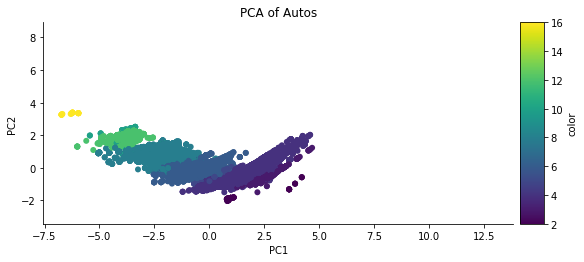

In [50]:
# Want names of PC1, PC2	
def fix_naming(name):
    return f"{name.upper()[:2]}{int(name[-1])+1}"

print(res.rename(fix_naming).columns)
HR()

(
    res
    .rename(fix_naming)
    .with_columns(color=autos['cylinders'])
    .hvplot.scatter(
        'PC1', 
        'PC2', 
        color='color',
        title='PCA of Autos',
        cmap='viridis'
    )
)

* This is a scatter plot of the first 2 principal components of the autos data.
* The points are colored by the number of cylinders in the car.
* This shows that scikit-learn works well Polars.
* scikit-learn can also output Polars natively.

---
# 8.17 Polars Configuration
[back to Top](#Top)

* Polars has a configuration system that allows you to set options for the library.
* You can set options globally or for a specific dataframe.
* You can also temporarily set options using the pl.Config object as a context manager, to set options for a specific code block.